# ML Dataset stats

I want to perform some verification on the ml dataset I generated.

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import dask.distributed
import logging
import pathlib
import xarray as xr
import torch
import torch.distributions
import seaborn as sns

from crims2s.dask import create_dask_cluster
from crims2s.util import add_biweekly_dim

In [108]:
#ML_DATASET_DIR = '***BASEDIR***/mlready/2021-08-08-test/'
ML_DATASET_DIR = '***BASEDIR***/mlready/2021-08-28-test'

In [109]:
ML_DATASET_DIR = '***BASEDIR***/mlready/2021-09-07-test-set'

In [110]:
ML_DATASET_DIR = '***BASEDIR***/mlready/2021-09-07-cube-train/'

## Load dataset

In [111]:
def preprocess_one_example(dataset):
    return dataset.expand_dims('forecast_time')

In [112]:
dataset_files = sorted([x for x in pathlib.Path(ML_DATASET_DIR).iterdir() if '.nc' in x.name])

In [113]:
dataset_files[:10]

[PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20000123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20010123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20020123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20030123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20040123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20050123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20060123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20070123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20080123.nc'),
 PosixPath('***BASEDIR***/mlready/2021-09-07-cube-train/train_example_20090123.nc')]

In [116]:
features = xr.open_mfdataset(dataset_files[:3], group='/features', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [117]:
model = xr.open_mfdataset(dataset_files[:3], group='/model', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [119]:
obs = xr.open_mfdataset(dataset_files[:3], group='/obs', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [118]:
parameters = xr.open_mfdataset(dataset_files[:3], group='/model_parameters', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [120]:
parameters

<xarray.Dataset>
Dimensions:             (forecast_time: 3, latitude: 121, longitude: 240, biweekly_forecast: 2)
Coordinates:
  * forecast_time       (forecast_time) datetime64[ns] 2000-01-23 ... 2002-01-23
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_monthday   <U4 '0123'
    forecast_year       (forecast_time) int64 2000 2001 2002
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 14 days 28 days
    lead_time           timedelta64[ns] 13 days
    valid_time          (forecast_time, biweekly_forecast) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables:
    t2m_mu              (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    t2m_sigma           (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_alpha            (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_beta             (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_mu               (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_sigma            (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_cube_root_mu     (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_cube_root_sigma  (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>

In [ ]:
model

In [ ]:
parameters

In [ ]:
obs.isnull().sum().compute()

In [ ]:
features

In [ ]:
obs

In [ ]:
len(obs.lead_time)

In [ ]:
46 / 7

In [ ]:
some_computed = sample.isnull().sum(dim=['latitude', 'longitude', 'realization'])

In [ ]:
some_computed.sum(dim=['variable', 'forecast_time']).compute().x.plot()

In [ ]:
some_computed.isel(lead_time=[0, 1]).sum(dim='variable').compute()

In [ ]:
sample.sel(variable='sst').isel(lead_time=slice(1, None)).sum(dim=['forecast_time', 'lead_time', 'realization']).compute().x.plot()

## Check y

In [ ]:
target = xr.open_mfdataset(dataset_files[:10], group='/terciles', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [ ]:
target = target.compute()

In [ ]:
target

In [ ]:
target.isnull().isel(forecast_time=0).sum(dim=['category', 'lead_time']).t2m.plot()

# Check obs

In [ ]:
obs = xr.open_mfdataset(dataset_files[:10], group='/obs', concat_dim='forecast_time', preprocess=preprocess_one_example)

In [ ]:
obs.isnull().sum(dim=['forecast_time', 'lead_time']).t2m.plot()

In [ ]:
model_params = xr.open_mfdataset(dataset_files, group='/model_parameters', preprocess=preprocess_one_example)

In [ ]:
model_params

# Check parameters fit

## For T2M

In [153]:
model_biweekly = add_biweekly_dim(model, weeks_12=False)

In [154]:
model_biweekly

,Array,Chunk
Bytes,102.36 MiB,17.06 MiB
Shape,"(2, 3, 14, 121, 240, 11)","(1, 1, 14, 121, 240, 11)"
Count,85 Tasks,6 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,102.36 MiB,17.06 MiB
Shape,"(2, 3, 14, 121, 240, 11)","(1, 1, 14, 121, 240, 11)"
Count,146 Tasks,6 Chunks
Type,float32,numpy.ndarray


In [155]:
reworked_t2m = model_biweekly.isel(lead_time=slice(1, None)).t2m.squeeze().transpose('realization', 'lead_time', 'forecast_time', ...)

In [156]:
reworked_t2m

,Array,Chunk
Bytes,95.05 MiB,15.84 MiB
Shape,"(11, 13, 3, 2, 121, 240)","(11, 13, 1, 1, 121, 240)"
Count,97 Tasks,6 Chunks
Type,float32,numpy.ndarray


In [157]:
t2m_data = torch.tensor(reworked_t2m.data.compute())

In [158]:
t2m_mu = torch.tensor(parameters.t2m_mu.squeeze().data.compute())
t2m_sigma = torch.tensor(parameters.t2m_sigma.squeeze().data.compute())

In [159]:
t2m_mu.max()

tensor(305.7250)

In [160]:
t2m_mu.shape

torch.Size([3, 2, 121, 240])

In [161]:
t2m_data.shape

torch.Size([11, 13, 3, 2, 121, 240])

In [162]:
distribution = torch.distributions.Normal(t2m_mu, t2m_sigma)

In [163]:
-distribution.log_prob(t2m_data).mean()

tensor(1.9875)

## For TP

In [124]:
tp_data = torch.tensor(model_biweekly.isel(lead_time=-1).tp.squeeze().transpose('realization', 'forecast_time', ...).data.compute())

In [125]:
tp_data.shape

torch.Size([11, 3, 2, 121, 240])

In [126]:
parameters

<xarray.Dataset>
Dimensions:             (forecast_time: 3, latitude: 121, longitude: 240, biweekly_forecast: 2)
Coordinates:
  * forecast_time       (forecast_time) datetime64[ns] 2000-01-23 ... 2002-01-23
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_monthday   <U4 '0123'
    forecast_year       (forecast_time) int64 2000 2001 2002
  * biweekly_forecast   (biweekly_forecast) timedelta64[ns] 14 days 28 days
    lead_time           timedelta64[ns] 13 days
    valid_time          (forecast_time, biweekly_forecast) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables:
    t2m_mu              (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    t2m_sigma           (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_alpha            (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_beta             (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_mu               (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_sigma            (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_cube_root_mu     (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>
    tp_cube_root_sigma  (forecast_time, biweekly_forecast, latitude, longitude) float32 dask.array<chunksize=(1, 2, 121, 240), meta=np.ndarray>

In [168]:
tp_mu = torch.tensor(parameters.tp_cube_root_mu.squeeze().data.compute())
tp_sigma = torch.tensor(parameters.tp_cube_root_sigma.squeeze().data.compute())

In [169]:
tp_sigma.min()

tensor(0.)

In [170]:
distribution = torch.distributions.Normal(tp_mu, tp_sigma + 1e-9)

In [172]:
-distribution.log_prob(tp_data ** (1. / 3.)).mean()

tensor(0.4994)

In [152]:
tp_alpha = torch.tensor(parameters.tp_alpha.squeeze().data.compute())
tp_beta = torch.tensor(parameters.tp_beta.squeeze().data.compute())

In [ ]:
distribution = torch.distributions.Gamma(tp_alpha, tp_beta)

In [ ]:
-distribution.log_prob(tp_data + 1e-9).mean()

In [140]:
tp_data.min()

tensor(0.)

In [ ]:
tp_mu.min()

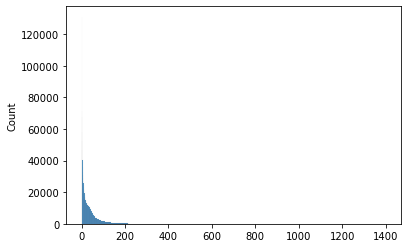

In [142]:
sns.histplot(data=tp_data.flatten())